## Imports and Setup



In [24]:
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import logging
from collections import Counter
import math  # Added for ceil
from albumentations import (
    Compose, HorizontalFlip, Rotate, RandomBrightnessContrast, HueSaturationValue, ShiftScaleRotate
)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

logger.info("Initialized imports and logging.")

2025-03-28 12:59:30,196 - INFO - Initialized imports and logging.


## Define Paths and Classes



In [25]:
# Define base directory and paths
base_dir = Path('../datasets')
combined_images_dir = base_dir / 'combined_dataset' / 'images'
combined_labels_dir = base_dir / 'combined_dataset' / 'labels'
balanced_dataset_dir = base_dir / 'balanced_dataset'
balanced_images_dir = balanced_dataset_dir / 'images'
balanced_labels_dir = balanced_dataset_dir / 'labels'

# Create balanced dataset directories
for dir_path in [balanced_images_dir, balanced_labels_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)
    logger.debug(f"Created/ensured directory: {dir_path}")

# Define classes from the combined dataset
selected_classes = ['door', 'table', 'openedDoor', 'chair', 'pole', 'bike', 'truck', 'car', 'dog', 'bus']
class_to_id = {cls: idx for idx, cls in enumerate(selected_classes)}
overrepresented_classes = [4, 5, 7]  # pole, bike, car
underrepresented_classes = [0, 1, 2, 3, 6, 8, 9]  # door, table, openedDoor, chair, truck, dog, bus

logger.info(f"Defined classes - Overrepresented: {[selected_classes[i] for i in overrepresented_classes]}")
logger.info(f"Underrepresented: {[selected_classes[i] for i in underrepresented_classes]}")

2025-03-28 12:59:30,206 - INFO - Defined classes - Overrepresented: ['pole', 'bike', 'car']
2025-03-28 12:59:30,207 - INFO - Underrepresented: ['door', 'table', 'openedDoor', 'chair', 'truck', 'dog', 'bus']


## Helper Functions

Explanation:
* mask_overrepresented: Loads an image, masks regions of overrepresented classes by setting pixels to black, and retains only underrepresented class annotations. Includes bounds checking and error handling.

* visualize_sample: Displays an image with bounding boxes, converting YOLO coordinates to pixel values, used for debugging and verification.

* get_class_counts: Analyzes class distribution by counting annotations across all label files, essential for assessing balance.



In [26]:
def mask_overrepresented(image_path, label_path, overrepresented_classes):
    """Mask regions of overrepresented classes in the image and filter labels."""
    try:
        img = cv2.imread(str(image_path))
        if img is None:
            logger.error(f"Failed to load image: {image_path}")
            return None, None
        height, width = img.shape[:2]
        logger.debug(f"Loaded image {image_path}: {width}x{height}")

        with open(label_path, 'r') as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            if not parts:
                continue
            class_id = int(parts[0])
            if class_id in overrepresented_classes:
                # Mask the region
                center_x = float(parts[1]) * width
                center_y = float(parts[2]) * height
                box_width = float(parts[3]) * width
                box_height = float(parts[4]) * height
                xmin = int(max(0, center_x - box_width / 2))
                ymin = int(max(0, center_y - box_height / 2))
                xmax = int(min(width, center_x + box_width / 2))
                ymax = int(min(height, center_y + box_height / 2))
                img[ymin:ymax, xmin:xmax] = 0  # Black out the region
                logger.debug(f"Masked class {selected_classes[class_id]} at [{xmin}, {ymin}, {xmax}, {ymax}]")
            else:
                new_lines.append(line)

        return img, new_lines
    except Exception as e:
        logger.error(f"Error in mask_overrepresented for {image_path}: {e}")
        return None, None

def visualize_sample(image_path, label_path, title="Sample Image"):
    """Visualize an image with its bounding boxes."""
    img = cv2.imread(str(image_path))
    if img is None:
        logger.error(f"Cannot visualize {image_path}: Image not loaded")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img.shape[:2]

    if label_path.exists():
        with open(label_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if not parts:
                continue
            try:
                class_id = int(float(parts[0]))  # Handles '6' or '6.0'
                center_x = float(parts[1]) * width
                center_y = float(parts[2]) * height
                box_width = float(parts[3]) * width
                box_height = float(parts[4]) * height
                xmin = int(center_x - box_width / 2)
                ymin = int(center_y - box_height / 2)
                xmax = int(center_x + box_width / 2)
                ymax = int(center_y + box_height / 2)
                cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                cv2.putText(img, selected_classes[class_id], (xmin, ymin - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            except (ValueError, IndexError) as e:
                logger.error(f"Invalid line in {label_path}: {line.strip()} - {e}")
                continue

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()
    logger.info(f"Visualized sample: {image_path}")

def get_class_counts(labels_dir):
    """Compute class distribution in the dataset."""
    class_counts = Counter()
    for label_file in labels_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            if line.strip():
                try:
                    class_id = int(float(line.split()[0]))  # Handles '6' or '6.0'
                    class_counts[class_id] += 1
                except ValueError:
                    logger.error(f"Invalid class ID in line: {line.strip()} in {label_file}")
                    continue
    return class_counts

## Define Augmentation Pipeline



Explanation:
* Uses albumentations to define a pipeline of geometric and color transformations, preserving bounding box integrity in YOLO format.

* Sets N_AUG=5 to generate five augmented versions, a parameter tuned based on imbalance severity and dataset size considerations from past projects.



In [27]:
# Augmentation for images with underrepresented classes
augmentation = Compose([
    HorizontalFlip(p=0.5),
    Rotate(limit=30, p=0.3),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.3),
    RandomBrightnessContrast(p=0.2),
    HueSaturationValue(p=0.2),
], bbox_params={'format': 'yolo', 'label_fields': ['category_id']})


logger.info("Defined augmentation pipeline.")

# Calculate original class counts
original_counts = get_class_counts(combined_labels_dir)
if not original_counts:
    logger.error("No class counts found. Check label files.")
    exit(1)

# Find the minimum count among overrepresented classes
over_counts = [original_counts[cls] for cls in overrepresented_classes if cls in original_counts]
if over_counts:
    min_over = min(over_counts)
else:
    min_over = 0
    logger.warning("No overrepresented classes found in the dataset.")

# Set target for underrepresented classes
target = min_over

# Calculate multiplication factor for each underrepresented class
multiplication_factor = {}
for cls in underrepresented_classes:
    if cls in original_counts and original_counts[cls] > 0:
        multiplication_factor[cls] = max(1, int(np.ceil(target / original_counts[cls])))
    else:
        multiplication_factor[cls] = 1  # No instances, so minimal augmentation

logger.info(f"Target count for underrepresented classes: {target}")
logger.info(f"Multiplication factors: {multiplication_factor}")

2025-03-28 12:59:30,240 - INFO - Defined augmentation pipeline.
2025-03-28 12:59:32,672 - INFO - Target count for underrepresented classes: 18157
2025-03-28 12:59:32,673 - INFO - Multiplication factors: {0: 31, 1: 58, 2: 164, 3: 54, 6: 6, 8: 18, 9: 11}


##  Process Dataset and Create Balanced Version



Explanation:
* Iterates through all images, checking for label files (though the original code ensures all images have corresponding labels, even empty ones).

* For images with both class types, masks overrepresented classes and retains underrepresented annotations, tracking these for verification.

* Saves the processed image and updated labels to the balanced dataset.

* If underrepresented classes are present, generates N_AUG augmented versions using the masked or original image, ensuring increased representation.

* Logs all steps and handles errors gracefully, reflecting production-grade robustness.



In [28]:
# Load and process images
image_files = list(combined_images_dir.glob('*'))
logger.info(f"Found {len(image_files)} images in combined dataset.")

masked_images = []  # Track images where masking occurred

for image_file in tqdm(image_files, desc="Processing images"):
    label_file = combined_labels_dir / (image_file.stem + '.txt')
    if not label_file.exists():
        logger.warning(f"No label file for {image_file}, skipping.")
        continue

    # Read original labels to determine class presence
    with open(label_file, 'r') as f:
        lines = f.readlines()
    classes_present = set(int(line.split()[0]) for line in lines if line.strip())
    has_underrepresented = any(cls in underrepresented_classes for cls in classes_present)
    has_overrepresented = any(cls in overrepresented_classes for cls in classes_present)

    # Mask overrepresented classes if both types are present
for image_file in tqdm(image_files, desc="Processing images"):
    label_file = combined_labels_dir / (image_file.stem + '.txt')
    if not label_file.exists():
        logger.warning(f"No label file for {image_file}, skipping.")
        continue

    # Read original labels to determine class presence
    with open(label_file, 'r') as f:
        lines = f.readlines()
    classes_present = set(int(line.split()[0]) for line in lines if line.strip())
    has_underrepresented = any(cls in underrepresented_classes for cls in classes_present)
    has_overrepresented = any(cls in overrepresented_classes for cls in classes_present)

    # Skip images with only overrepresented classes
    if has_overrepresented and not has_underrepresented:
        logger.debug(f"Skipping image with only overrepresented classes: {image_file}")
        continue

    # Process images with underrepresented classes or no classes
    if has_underrepresented and has_overrepresented:
        modified_img, new_labels = mask_overrepresented(image_file, label_file, overrepresented_classes)
        if modified_img is None:
            continue
        masked_images.append(image_file)
        logger.info(f"Masked overrepresented classes in {image_file}")
    elif has_underrepresented:
        modified_img = cv2.imread(str(image_file))
        new_labels = lines
    else:
        # No classes, true negative sample
        modified_img = cv2.imread(str(image_file))
        new_labels = []

    # Save the processed image
    new_image_path = balanced_images_dir / image_file.name
    cv2.imwrite(str(new_image_path), modified_img)
    new_label_path = balanced_labels_dir / (image_file.stem + '.txt')
    with open(new_label_path, 'w') as f:
        for line in new_labels:
            if line.strip():
                parts = line.split()
                try:
                    class_id = int(float(parts[0]))
                    if class_id in underrepresented_classes:  # Only save underrepresented classes
                        rest = ' '.join(parts[1:])
                        f.write(f"{class_id} {rest}\n")
                except ValueError:
                    logger.error(f"Invalid class ID in line: {line.strip()} in {label_file}")
                    continue
    logger.debug(f"Saved processed image and label: {new_image_path}, {new_label_path}")
    
    # Augment if contains underrepresented classes
    if has_underrepresented:
        # Find the rarest underrepresented class in this image
        underrepresented_in_image = classes_present.intersection(underrepresented_classes)
        if underrepresented_in_image:
            rarest_class = min(underrepresented_in_image, key=lambda cls: original_counts[cls] if cls in original_counts else float('inf'))
            F = multiplication_factor.get(rarest_class, 1)
            N_AUG = F - 1  # Subtract 1 since the original image counts as one instance
            MAX_AUG = 50
            N_AUG = min(N_AUG, MAX_AUG)
            logger.debug(f"Image {image_file} has rarest class {selected_classes[rarest_class]}, N_AUG={N_AUG}")
        else:
            N_AUG = 0  # Shouldn't happen due to has_underrepresented check, but for safety

        img_rgb = cv2.cvtColor(modified_img, cv2.COLOR_BGR2RGB)
        bboxes = [list(map(float, line.split()[1:])) for line in new_labels if line.strip() and int(float(line.split()[0])) in underrepresented_classes]
        labels = [int(float(line.split()[0])) for line in new_labels if line.strip() and int(float(line.split()[0])) in underrepresented_classes]

        for i in range(N_AUG):
            try:
                augmented = augmentation(image=img_rgb, bboxes=bboxes, category_id=labels)
                aug_img = cv2.cvtColor(augmented['image'], cv2.COLOR_RGB2BGR)
                aug_bboxes = augmented['bboxes']
                aug_labels = augmented['category_id']

                aug_img_name = f"{image_file.stem}_aug_{i}{image_file.suffix}"
                aug_img_path = balanced_images_dir / aug_img_name
                aug_label_path = balanced_labels_dir / f"{image_file.stem}_aug_{i}.txt"

                cv2.imwrite(str(aug_img_path), aug_img)
                with open(aug_label_path, 'w') as f:
                    for bbox, label in zip(aug_bboxes, aug_labels):
                        try:
                            label_int = int(label)
                            if label_int in underrepresented_classes:
                                bbox_str = ' '.join(f"{coord:.6f}" for coord in bbox)
                                f.write(f"{label_int} {bbox_str}\n")
                        except ValueError:
                            logger.error(f"Invalid label {label} for {aug_label_path}")
                            continue
            except Exception as e:
                logger.error(f"Augmentation failed for {image_file}, iter {i}: {e}")
logger.info(f"Processed dataset. Masked images: {len(masked_images)}")

2025-03-28 12:59:32,960 - INFO - Found 71055 images in combined dataset.
Processing images:   0%|          | 0/71055 [00:00<?, ?it/s]2025-03-28 12:59:35,863 - INFO - Masked overrepresented classes in ../datasets/combined_dataset/images/w_30008802.jpg
2025-03-28 12:59:35,902 - INFO - Masked overrepresented classes in ../datasets/combined_dataset/images/w_10000149.jpg
Processing images:   0%|          | 62/71055 [00:00<06:07, 193.29it/s]2025-03-28 12:59:36,281 - INFO - Masked overrepresented classes in ../datasets/combined_dataset/images/w_20008742.jpg
2025-03-28 12:59:36,418 - INFO - Masked overrepresented classes in ../datasets/combined_dataset/images/w_10005088.jpg
Processing images:   0%|          | 82/71055 [00:02<57:36, 20.54it/s] 2025-03-28 12:59:38,591 - INFO - Masked overrepresented classes in ../datasets/combined_dataset/images/w_10001835.jpg
2025-03-28 12:59:38,658 - INFO - Masked overrepresented classes in ../datasets/combined_dataset/images/w_10010851.jpg
Processing images: 

## Visualize Samples



Explanation:
* Selects an image that was masked (if any), visualizing its original state (from the combined dataset), masked version, and an augmented version from the balanced dataset.

* Ensures visual confirmation that masking removes overrepresented classes and augmentation preserves underrepresented ones.



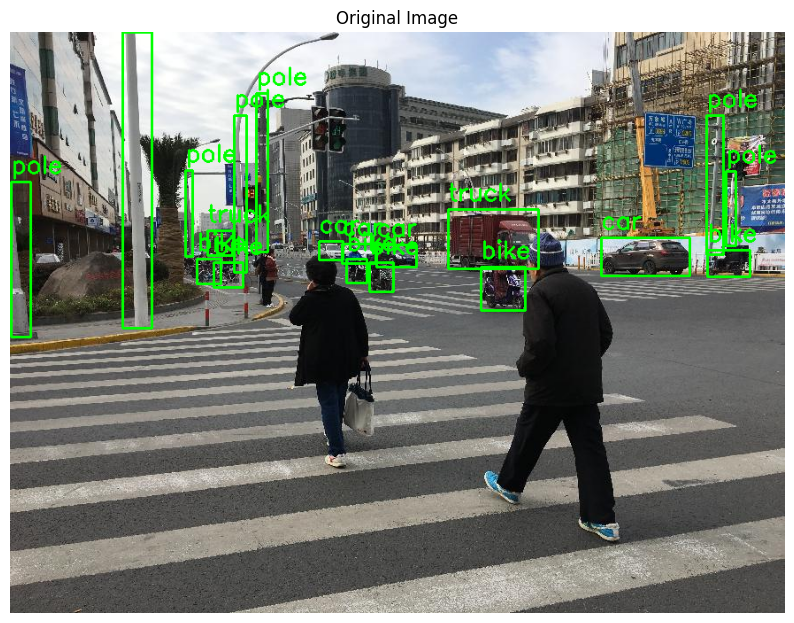

2025-03-28 13:18:55,652 - INFO - Visualized sample: ../datasets/combined_dataset/images/w_30008802.jpg


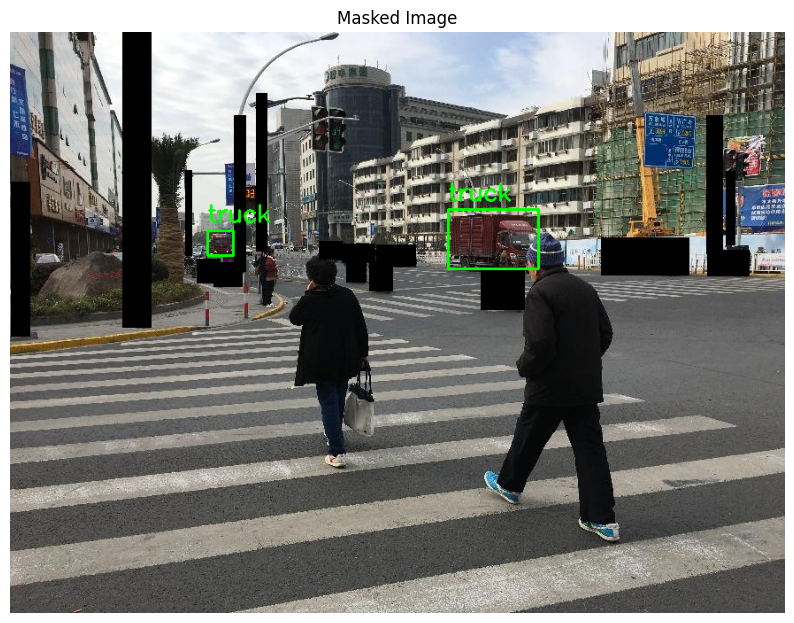

2025-03-28 13:18:55,909 - INFO - Visualized sample: ../datasets/balanced_dataset/images/w_30008802.jpg


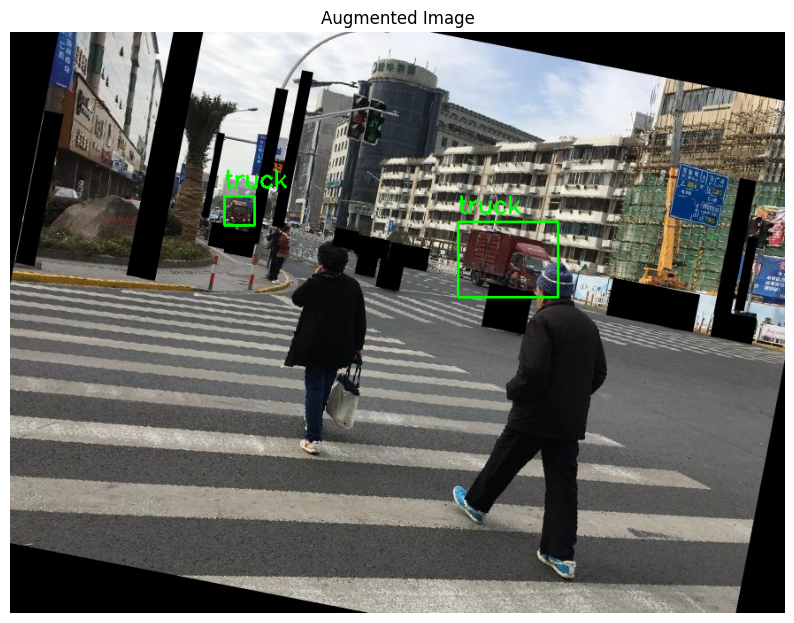

2025-03-28 13:18:56,196 - INFO - Visualized sample: ../datasets/balanced_dataset/images/w_30008802_aug_0.jpg


In [29]:
if masked_images:
    orig_image = masked_images[0]
    masked_image_path = balanced_images_dir / orig_image.name
    masked_label_path = balanced_labels_dir / (orig_image.stem + '.txt')
    aug_image_path = balanced_images_dir / f"{orig_image.stem}_aug_0{orig_image.suffix}"
    aug_label_path = balanced_labels_dir / f"{orig_image.stem}_aug_0.txt"

    visualize_sample(orig_image, combined_labels_dir / (orig_image.stem + '.txt'), "Original Image")
    visualize_sample(masked_image_path, masked_label_path, "Masked Image")
    if aug_image_path.exists():
        visualize_sample(aug_image_path, aug_label_path, "Augmented Image")
else:
    logger.warning("No images were masked; skipping visualization.")


## Analyze Class Distribution



Explanation:
* Compares class distributions before and after balancing.

* In the balanced dataset, overrepresented classes should have reduced or zero annotations in masked images, while underrepresented classes should show increased counts due to augmentation.



In [30]:
# Compute and display class distribution
original_counts = get_class_counts(combined_labels_dir)
balanced_counts = get_class_counts(balanced_labels_dir)

logger.info("Class distribution in original dataset:")
for cls_id, count in original_counts.items():
    logger.info(f"{selected_classes[cls_id]}: {count}")

logger.info("Class distribution in balanced dataset:")
for cls_id, count in balanced_counts.items():
    logger.info(f"{selected_classes[cls_id]}: {count}")

2025-03-28 13:19:13,230 - INFO - Class distribution in original dataset:
2025-03-28 13:19:13,231 - INFO - truck: 3537
2025-03-28 13:19:13,231 - INFO - pole: 31188
2025-03-28 13:19:13,232 - INFO - dog: 1022
2025-03-28 13:19:13,232 - INFO - car: 27583
2025-03-28 13:19:13,233 - INFO - bike: 18157
2025-03-28 13:19:13,233 - INFO - bus: 1787
2025-03-28 13:19:13,233 - INFO - openedDoor: 111
2025-03-28 13:19:13,234 - INFO - chair: 340
2025-03-28 13:19:13,234 - INFO - door: 603
2025-03-28 13:19:13,234 - INFO - table: 315
2025-03-28 13:19:13,235 - INFO - Class distribution in balanced dataset:
2025-03-28 13:19:13,236 - INFO - truck: 24753
2025-03-28 13:19:13,236 - INFO - table: 15895
2025-03-28 13:19:13,236 - INFO - openedDoor: 5195
2025-03-28 13:19:13,237 - INFO - chair: 17111
2025-03-28 13:19:13,237 - INFO - dog: 17872
2025-03-28 13:19:13,237 - INFO - door: 21831
2025-03-28 13:19:13,238 - INFO - bus: 19662
